# 1D Forward Simulation for a Single Sounding

reference: simpeg user tutorials 
https://github.com/simpeg/user-tutorials

In [3]:
# simpeg functionality
import simpeg.electromagnetics.time_domain as tdem
from simpeg import maps
from simpeg.utils import plot_1d_layer_model

# discretize functionality
from discretize import CylindricalMesh, TensorMesh

# Common Python functionality
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.constants import mu_0
import pandas as pd

### Defining Survey

The survey composes of the following fours components: 
- **receivers:** There are a multitude of TDEM receiver classes within SimPEG, each of which is used to simulate data corresponding to a different field measurement; e.g. [PointMagneticField](xref:simpeg#simpeg.electromagnetics.time_domain.receivers.PointMagneticField), [PointMagneticFluxTimeDerivative](xref:simpeg#simpeg.electromagnetics.time_domain.receivers.PointMagneticFluxTimeDerivative) and [PointElectricField](xref:simpeg#simpeg.electromagnetics.time_domain.receivers.PointElectricField). The properties for each TDEM receiver object generally include: the orientation of the field being measured (x, y, z, other), the time channels, the data type, and one or more associated observation locations.
- **sources:** There are a multitude of TDEM source classes within SimPEG, each of which corresponds to a different geometry; e.g. [MagDipole](xref:simpeg#simpeg.electromagnetics.time_domain.sources.MagDipole) and [LineCurrent](xref:simpeg#simpeg.electromagnetics.time_domain.sources.LineCurrent). Source classes generally require the user to define the current waveform, location and geometry.
- **waveforms:** The waveform defining the time-dependent current in the source is defined by an object in SimPEG. Some waveform classes include [StepOffWaveform](xref:simpeg#simpeg.electromagnetics.time_domain.sources.StepOffWaveform), [VTEMWaveform](xref:simpeg#simpeg.electromagnetics.time_domain.sources.VTEMWaveform) and [RawWaveform](xref:simpeg#simpeg.electromagnetics.time_domain.sources.RawWaveform)
- **survey:** The object which stores and organizes all of the sources and receivers.


In [5]:
# Source properties
source_location = np.array([0.0, 0.0, 1.0])  # (3, ) numpy.array_like
source_orientation = "z"  # "x", "y" or "z"
source_current = 1.0  # maximum on-time current (A)
source_radius = 10.0  # source loop radius (m)

# Receiver properties
receiver_locations = np.array([0.0, 0.0, 1.0])  # or (N, 3) numpy.ndarray
receiver_orientation = "z"  # "x", "y" or "z"
times = np.logspace(-5, -2, 31)  # time channels (s)

In [6]:
stepoff_waveform = tdem.sources.StepOffWaveform(off_time=0.0)

In [7]:
# Define receiver list. In our case, we have only a single receiver for each source.
# When simulating the response for multiple data types for the same source, the list consists of multiple receiver objects.
receiver_list = []
receiver_list.append(
    tdem.receivers.PointMagneticFluxDensity(
        receiver_locations, times, orientation=receiver_orientation
    )
)

# Define source list. In our case, we have only a single source.
source_list = [
    tdem.sources.CircularLoop(
        receiver_list=receiver_list,
        location=source_location,
        waveform=stepoff_waveform,
        current=source_current,
        radius=source_radius,
    )
]

# Define the survey
survey = tdem.Survey(source_list)

### Define 1D Layered Earth and Model

In [9]:
# Layer conductivities
layer_conductivities = np.r_[0.1, 1.0, 0.1]

# Layer thicknesses
layer_thicknesses = np.r_[40.0, 40.0]

# Number of layers
n_layers = len(layer_conductivities)

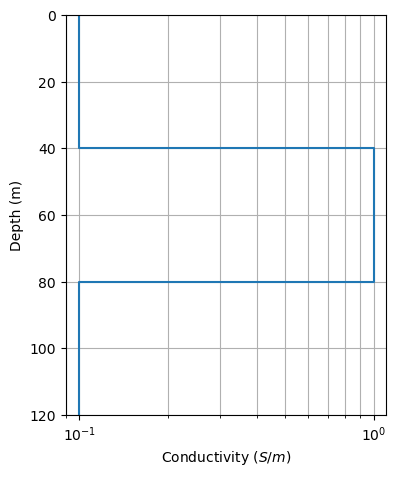

In [10]:
fig = plt.figure(figsize=(4, 5))
ax1 = fig.add_axes([0.1, 0.1, 0.8, 0.8])
ax1 = plot_1d_layer_model(layer_thicknesses, layer_conductivities, scale="log", ax=ax1) # from simpeg
ax1.grid(which="both")
ax1.set_xlabel(r"Conductivity ($S/m$)")
plt.show()

**1. Conductivity model:** For forward simulation, the easiest approach is to define the model as the layer conductivities and set the layer thicknesses as a static property of the 1D simulation. In this case, the mapping from the model to the conductivities is defined using the [simpeg.maps.IdentityMap](xref:simpeg#simpeg.maps.IdentityMap) class.

**2. Parametric layered Earth model:** In this case, the model parameters are log-resistivities and layer thicknesses. We therefore need a mapping that extracts log-resistivities from the model and converts them into resistivities, and a mapping that extracts layer thicknesses from the model. For this, we require the [simpeg.maps.Wires](xref:simpeg#simpeg.maps.Wires) mapping and [simpeg.maps.ExpMap](xref:simpeg#simpeg.maps.ExpMap) mapping classes.

In [12]:
# Define model and mapping for a conductivity model.
conductivity_model = layer_conductivities.copy()
conductivity_map = maps.IdentityMap(nP=n_layers)

# Define model and mappings for the parametric model.
# Note the ordering in which you defined the model parameters and the
# order in which you defined the wire mappings matters!!!
parametric_model = np.r_[layer_thicknesses, np.log(1 / layer_conductivities)]
wire_map = maps.Wires(("thicknesses", n_layers - 1), ("log_resistivity", n_layers))
thicknesses_map = wire_map.thicknesses
log_resistivity_map = maps.ExpMap() * wire_map.log_resistivity

### Define forward simluation

In [14]:
simulation_conductivity = tdem.simulation_1d.Simulation1DLayered(
    survey=survey,
    sigmaMap=conductivity_map,
    thicknesses=layer_thicknesses,
)

In [15]:
simulation_parametric = tdem.simulation_1d.Simulation1DLayered(
    survey=survey,
    rhoMap=log_resistivity_map,
    thicknessesMap=thicknesses_map,
)

In [16]:
dpred_conductivity = simulation_conductivity.dpred(conductivity_model)
dpred_parametric = simulation_parametric.dpred(parametric_model)

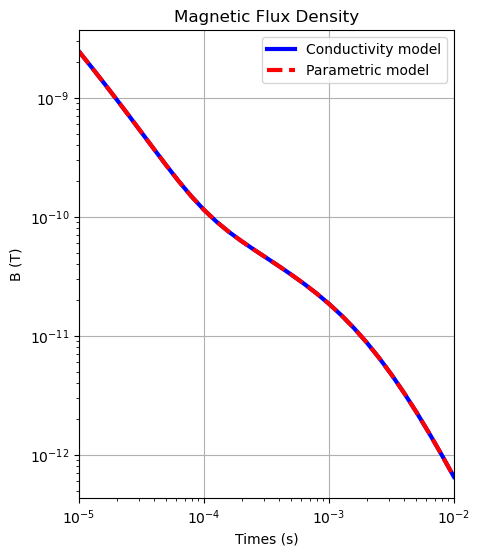

In [17]:
fig = plt.figure(figsize=(5, 6))
ax = fig.add_axes([0.2, 0.15, 0.75, 0.78])
ax.loglog(times, dpred_conductivity, "b-", lw=3)
ax.loglog(times, dpred_parametric, "r--", lw=3)
ax.set_xlim([times.min(), times.max()])
ax.grid()
ax.set_xlabel("Times (s)")
ax.set_ylabel("B (T)")
ax.set_title("Magnetic Flux Density")
ax.legend(["Conductivity model", "Parametric model"])
plt.show()

### Explore layer with different physcial properties

In [19]:
#1 conductive layer is also magnetically permeable 
layer_susceptibilities = np.r_[0.0, 9.0, 0.0]
layer_permeabilities = mu_0 * (1 + layer_susceptibilities) # mu_0 is a constant 

simulation_permeable = tdem.simulation_1d.Simulation1DLayered(
    survey=survey,
    sigmaMap=conductivity_map,
    thicknesses=layer_thicknesses,
    mu=layer_permeabilities, # additional line to define layer's magnetic permeability 
)

dpred_permeable = simulation_permeable.dpred(conductivity_model)

In [20]:
#2 conductive layer is also chargeable 
eta = 0.5  # intrinsic chargeability [0, 1]
tau = 0.001  # central time-relaxation constant in seconds
c = 0.8  # phase constant [0, 1]

layer_eta = np.r_[1e-10, eta, 1e-10]
layer_tau = np.r_[0.0, tau, 0.0]
layer_c = np.r_[0.0, c, 0.0]

simulation_ip = tdem.Simulation1DLayered(
    survey=survey,
    thicknesses=layer_thicknesses,
    sigmaMap=conductivity_map,
    eta=layer_eta, # additional line to define layer's chargeability 
    tau=layer_tau, #..
    c=layer_c, #..
)

dpred_ip = simulation_ip.dpred(conductivity_model)

In [21]:
#3 top layer exhibits super-paramagnetism (SPM)
chi = 0.01  # infinite susceptibility in SI
dchi = 0.01  # amplitude of frequency-dependent susceptibility contribution
tau1 = 1e-7  # lower limit for time relaxation constants in seconds
tau2 = 1.0  # upper limit for time relaxation constants in seconds

layer_mu = mu_0 * (1 + chi * np.r_[1.0, 0.0, 0.0])  # convert to permeability
layer_dchi = chi * np.r_[1.0, 0.0, 0.0]
layer_tau1 = tau1 * np.r_[1.0, 0.0, 0.0]
layer_tau2 = tau1 * np.r_[1.0, 0.0, 0.0]

simulation_spm = tdem.Simulation1DLayered(
    survey=survey,
    thicknesses=layer_thicknesses,
    sigmaMap=conductivity_map,
    mu=mu_0,
    dchi=dchi,
    tau1=tau1,
    tau2=tau2,
)

dpred_spm = simulation_spm.dpred(conductivity_model)

/Applications/anaconda3/envs/simpeg-env/lib/python3.9/site-packages/numpy/core/_asarray.py:126: ComplexWarning: Casting complex values to real discards the imaginary part
  arr = array(a, dtype=dtype, order=order, copy=False, subok=subok)


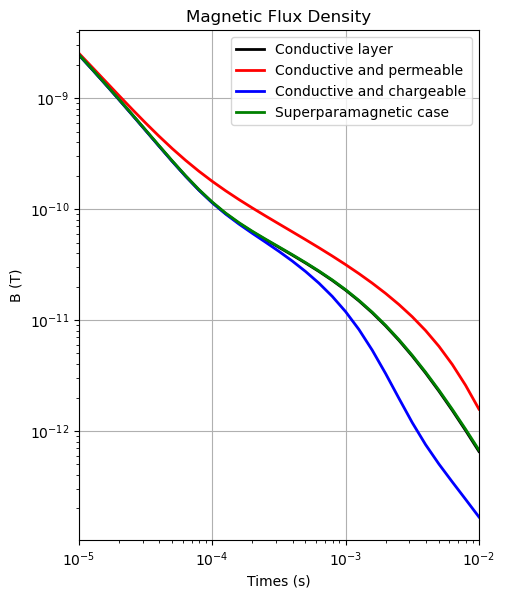

In [22]:
fig = plt.figure(figsize=(5, 6))
ax1 = fig.add_axes([0.1, 0.1, 0.8, 0.85])
ax1.loglog(times, np.abs(dpred_conductivity[0 : len(times)]), "k", lw=2)
ax1.loglog(times, np.abs(dpred_permeable[0 : len(times)]), "r", lw=2)
ax1.loglog(times, np.abs(dpred_ip[0 : len(times)]), "b", lw=2)
ax1.loglog(times, np.abs(dpred_spm[0 : len(times)]), "g", lw=2)
ax1.set_xlim([times.min(), times.max()])
ax1.grid()
ax1.legend(
    [
        "Conductive layer",
        "Conductive and permeable",
        "Conductive and chargeable",
        "Superparamagnetic case",
    ]
)
ax1.set_xlabel("Times (s)")
ax1.set_ylabel("B (T)")
ax1.set_title("Magnetic Flux Density")
plt.show()

### Explore results from different transmitter waveforms

- Rectangular waveform (used in SkyTEM for HM?)
- Triangular waveform
- General waveform
- Step-off (used above)

In [24]:
# Rectangular waveform. The user may customize the waveform by setting the start
# time, end time and on time amplitude for the current waveform.
eps = 1e-6
ramp_on = np.r_[-0.004, -0.004 + eps]
ramp_off = np.r_[-eps, 0.0]
rectangular_waveform = tdem.sources.TrapezoidWaveform(
    ramp_on=ramp_on, ramp_off=ramp_off
)

In [25]:
# Triangular waveform. The user may customize the waveform by setting the start
# time, peak time, end time and peak amplitude for the current waveform.
eps = 1e-8
start_time = -0.02
peak_time = -0.01
off_time = 0.0
triangle_waveform = tdem.sources.TriangularWaveform(
    start_time=start_time, peak_time=peak_time, off_time=off_time
)

In [26]:
# General waveform. This is a fully general way to define the waveform.
# The use simply provides times and the current.


def custom_waveform(t, tmax):
    out = np.cos(0.5 * np.pi * (t - tmax) / (tmax + 0.02))
    out[t >= tmax] = 1 + (t[t >= tmax] - tmax) / tmax
    return out


waveform_times = np.r_[np.linspace(-0.02, -0.011, 10), -np.logspace(-2, -6, 61), 0.0]
waveform_current = custom_waveform(waveform_times, -0.0055)
general_waveform = tdem.sources.PiecewiseLinearWaveform(
    times=waveform_times, currents=waveform_current
)

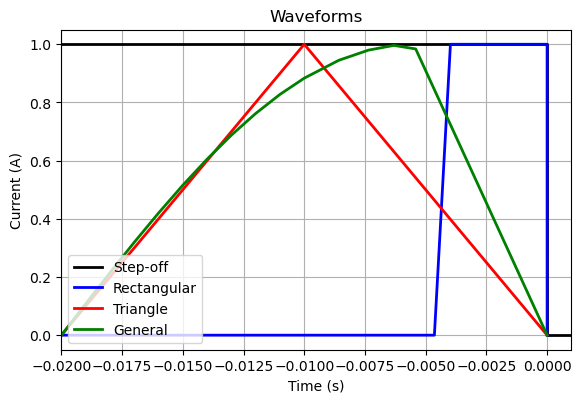

In [27]:
fig = plt.figure(figsize=(6, 4))
ax = fig.add_axes([0.1, 0.1, 0.85, 0.8])

ax.plot(np.r_[-2e-2, 0.0, 1e-10, 1e-3], np.r_[1.0, 1.0, 0.0, 0.0], "k", lw=2)
plotting_current = [rectangular_waveform.eval(t) for t in waveform_times]
ax.plot(waveform_times, plotting_current, "b", lw=2)
plotting_current = [triangle_waveform.eval(t) for t in waveform_times]
ax.plot(waveform_times, plotting_current, "r", lw=2)
plotting_current = [general_waveform.eval(t) for t in waveform_times]
ax.plot(waveform_times, plotting_current, "g", lw=2)

ax.grid()
ax.set_xlim([waveform_times.min(), 1e-3])
ax.set_xlabel("Time (s)")
ax.set_ylabel("Current (A)")
ax.set_title("Waveforms")
ax.legend(["Step-off", "Rectangular", "Triangle", "General"], loc="lower left")
plt.show()

### Examining different waveforms using a survey with multiple sources

In [29]:
waveforms_list = [
    stepoff_waveform,
    rectangular_waveform,
    triangle_waveform,
    general_waveform,
]

In [30]:
source_list_multi = []

for w in waveforms_list:
    # using same receiver data in the 'z' direction
    receiver_list_multi = [
        tdem.receivers.PointMagneticFluxDensity(
            receiver_locations, times, orientation=receiver_orientation
        )
    ]
    # create one object for each waveform
    source_list_multi.append(
        tdem.sources.CircularLoop(
            receiver_list=receiver_list_multi,
            location=source_location,
            waveform=w,
            current=source_current,
            radius=source_radius,
        )
    )

# Define the survey
survey_multi = tdem.Survey(source_list_multi)

In [31]:
simulation_waveforms = tdem.Simulation1DLayered(
    survey=survey_multi, thicknesses=layer_thicknesses, sigmaMap=conductivity_map
)


dpred_waveforms = simulation_waveforms.dpred(conductivity_model)

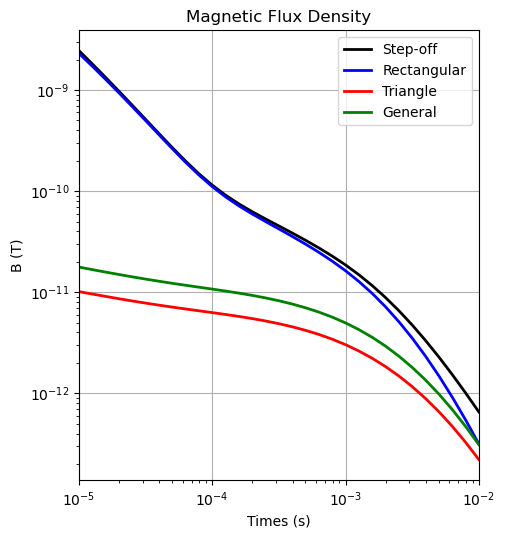

In [32]:
fig = plt.figure(figsize=(5, 6))
d = np.reshape(dpred_waveforms, (len(source_list_multi), len(times))).T
ax = fig.add_axes([0.15, 0.15, 0.8, 0.75])
colorlist = ["k", "b", "r", "g"]
for ii, k in enumerate(colorlist):
    ax.loglog(times, np.abs(d[:, ii]), k, lw=2)

ax.set_xlim([times.min(), times.max()])
ax.grid()
ax.legend(["Step-off", "Rectangular", "Triangle", "General"])
ax.set_xlabel("Times (s)")
ax.set_ylabel("B (T)")
ax.set_title("Magnetic Flux Density")
plt.show()

### Use SkyTEM receiver, transmitter and waveform 

LM and HM gate centre time (s):

In [35]:
# load the gate opening time for LM and HM respectively
LM_excel = "../../LM_times.csv"
HM_excel = "../../HM_times.csv"
LM_times_csv = pd.read_csv(LM_excel, 
                 #delim_whitespace=True,
                 delimiter=",") 
HM_times_csv = pd.read_csv(HM_excel, 
                 #delim_whitespace=True,
                 delimiter=",") 

In [36]:
# extract gate_centre (s)
LM_times = LM_times_csv["Gate Centre (s)"].to_numpy()
HM_times = HM_times_csv["Gate Centre (s)"].to_numpy()

Receiver and Transmitter:

In [38]:
# shape of the transmitter, and the offset of the receiver coil.
tx_shape = np.array([ 
    [-12.64,  -2.13,   300.  ],
    [ -6.15,  -8.59,   300.  ],
    [  5.74,  -8.59,   300.  ],
    [ 11.13,  -3.19,   300.  ],
    [ 11.13,   3.19,   300.  ],
    [  5.74,   8.59,   300.  ],
    [ -6.15,   8.59,   300.  ],
    [-12.64,   2.13,   300.  ],
    [-12.64,  -2.13,   300.  ]])
rx_offset = np.array([-13.46,   0.  ,  298.  ]) # from data processing report

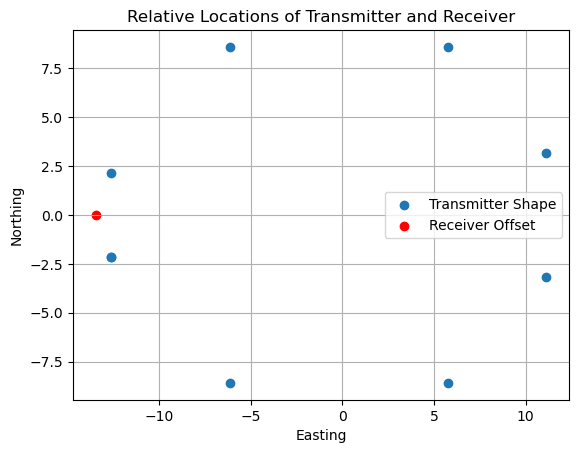

In [112]:
# Extract x and y coordinates for transmitter shape
tx_x = [point[0] for point in tx_shape]
tx_y = [point[1] for point in tx_shape]

# Scatter plot for transmitter shape
plt.scatter(tx_x, tx_y, label='Transmitter Shape')

# Scatter plot for receiver offset
plt.scatter(rx_offset[0], rx_offset[1], label='Receiver Offset', color='red')

# Add labels and legend
plt.xlabel('Easting')
plt.ylabel('Northing')
plt.title('Relative Locations of Transmitter and Receiver')
plt.legend()
plt.grid()

# Show the plot
plt.show()

Waveform:

In [41]:
LM_waveform_excel = "../../LM_waveform.csv"
HM_waveform_excel = "../../HM_waveform.csv"
LM_waveform_csv = pd.read_csv(LM_waveform_excel, 
                 #delim_whitespace=True,
                 delimiter=",") 
HM_waveform_csv = pd.read_csv(HM_waveform_excel, 
                 #delim_whitespace=True,
                 delimiter=",") 

In [42]:
# extract the time and form from waveform_csv 
LM_wave_time = LM_waveform_csv["Time (s)"]
LM_wave_form = LM_waveform_csv["Amplitude"]
HM_wave_time = HM_waveform_csv["Time (s)"]
HM_wave_form = HM_waveform_csv["Amplitude"]

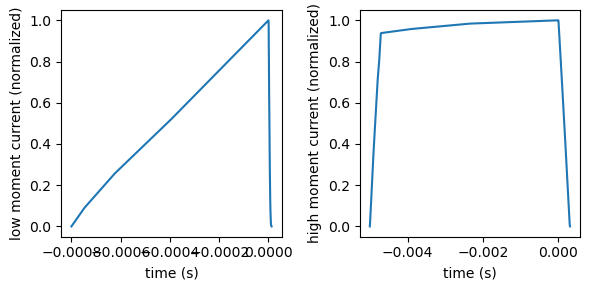

In [43]:
fig, ax = plt.subplots(1, 2, figsize=(6,3))
ax[0].plot(LM_wave_time, LM_wave_form)
ax[0].set_ylabel("low moment current (normalized)")
ax[0].set_xlabel("time (s)")

ax[1].plot(HM_wave_time, HM_wave_form)
ax[1].set_ylabel("high moment current (normalized)")
ax[1].set_xlabel("time (s)")

plt.tight_layout()

### Set up survey for forward simulation

In [45]:
# Low moment:
rx_lm = tdem.receivers.PointMagneticFluxTimeDerivative(
    rx_offset, LM_times, orientation='z'
)

lm_wave = tdem.sources.PiecewiseLinearWaveform(LM_wave_time, LM_wave_form)

src_lm = tdem.sources.LineCurrent(rx_lm, tx_shape, waveform=lm_wave)

In [46]:
# high moment
rx_hm = tdem.receivers.PointMagneticFluxTimeDerivative(
    rx_offset, HM_times, orientation='z'
)

hm_wave = tdem.sources.PiecewiseLinearWaveform(HM_wave_time, HM_wave_form)

src_hm = tdem.sources.LineCurrent(rx_hm, tx_shape, waveform=hm_wave)

In [47]:
survey_skytem = tdem.Survey([src_lm, src_hm])

### Define 1D Layered Earth and Model

1. Variation in conductivity

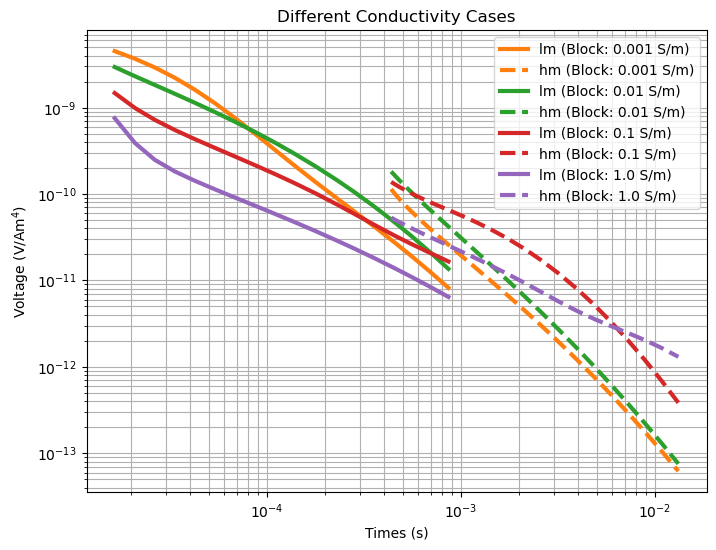

In [156]:
# Define the four conductivity cases
conductivity_cases = [
    [0.01, 1e-3, 0.01],
    [0.01, 1e-2, 0.01],
    [0.01, 1e-1, 0.01],
    [0.01, 1e0, 0.01]
]

# Layer thicknesses
layer_thicknesses = np.r_[25.0, 100.0] #[125.0, 25.0]

# Number of layers
n_layers = len(conductivity_cases[0])

# Plot each conductivity case on the same graph with different colors and labels
fig, ax = plt.subplots(figsize=(8, 6))

colors = ['C1', 'C2', 'C3', 'C4']

for i, conductivity_model in enumerate(conductivity_cases):
    # Define model and mapping for a conductivity model.
    conductivity_map = maps.IdentityMap(nP=n_layers)

    simulation_conductivity = tdem.Simulation1DLayered(
        survey_skytem,
        sigmaMap=conductivity_map,
        thicknesses=layer_thicknesses,
    )

    dpred_conductivity = simulation_conductivity.dpred(conductivity_model)

    dpred_lm = -dpred_conductivity[:18]
    dpred_hm = -dpred_conductivity[18:]

    ax.loglog(LM_times, dpred_lm, colors[i], lw=3, label=f"lm (Block: {conductivity_model[1]} S/m)")
    ax.loglog(HM_times, dpred_hm, colors[i], lw=3, linestyle='--', label=f"hm (Block: {conductivity_model[1]} S/m)")

ax.grid(which="both")
ax.set_xlabel("Times (s)")
ax.set_ylabel("Voltage (V/Am$^4$)")
ax.set_title("Different Conductivity Cases")
ax.legend()
plt.show()

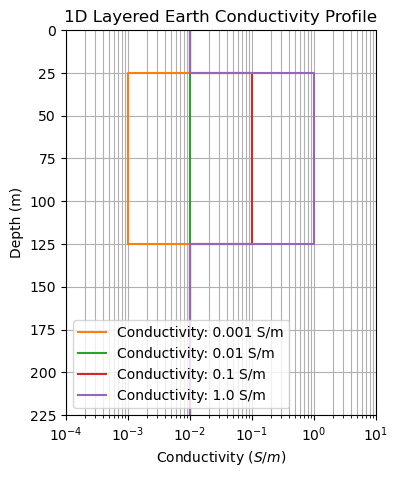

In [157]:
# Plot each conductivity profile
fig, ax = plt.subplots(figsize=(4, 5))

for i, conductivity_model in enumerate(conductivity_cases):
    plot_1d_layer_model(
        layer_thicknesses, conductivity_model, scale="log", ax=ax, color=colors[i], label=f"Conductivity: {conductivity_model[1]} S/m"
    )

ax.grid(which="both")
ax.set_title("1D Layered Earth Conductivity Profile")
ax.set_xlabel(r"Conductivity ($S/m$)")
ax.set_ylabel("Depth (m)")
ax.set_xlim(1e-4, 1e1)
ax.legend()
plt.show()


2. Variation in depth

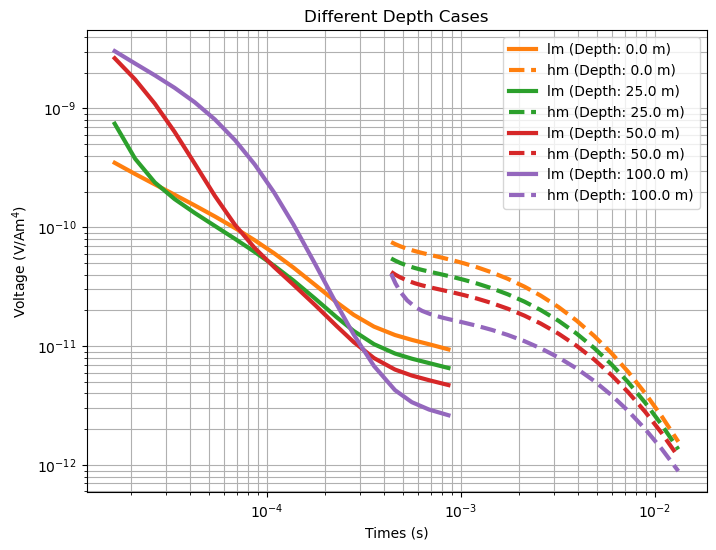

In [53]:
# Define the conductivity model
conductivity_model = [0.01, 1.0, 0.01]

# Define the four thickness cases
thickness_cases = [
    [0.0, 25.0],
    [25.0, 25.0],
    [50.0, 25.0],
    [100.0, 25.0]
]

# Plot each thickness case on the same graph with different colors and labels
fig, ax = plt.subplots(figsize=(8, 6))

colors = ['C1', 'C2', 'C3', 'C4', 'C5']

for i, layer_thicknesses in enumerate(thickness_cases):
    # Define model and mapping for a conductivity model.
    conductivity_map = maps.IdentityMap(nP=n_layers)

    simulation_conductivity = tdem.Simulation1DLayered(
        survey_skytem,
        sigmaMap=conductivity_map,
        thicknesses=layer_thicknesses,
    )

    dpred_conductivity = simulation_conductivity.dpred(conductivity_model)

    dpred_lm = -dpred_conductivity[:18]
    dpred_hm = -dpred_conductivity[18:]

    ax.loglog(LM_times, dpred_lm, colors[i], lw=3, label=f"lm (Depth: {layer_thicknesses[0]} m)")
    ax.loglog(HM_times, dpred_hm, colors[i], lw=3, linestyle='--', label=f"hm (Depth: {layer_thicknesses[0]} m)")

ax.grid(which="both")
ax.set_xlabel("Times (s)")
ax.set_ylabel("Voltage (V/Am$^4$)")
ax.set_title("Different Depth Cases")
ax.legend()
plt.show()


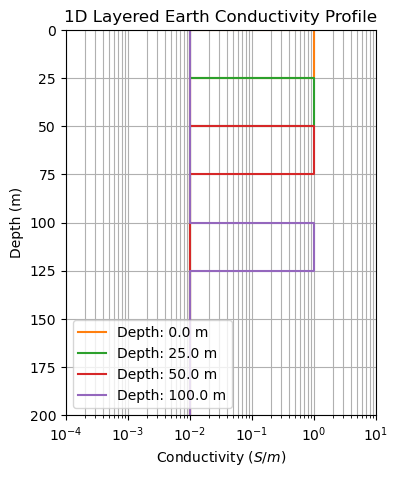

In [54]:
# Define the conductivity model
conductivity_model = [0.01, 1.0, 0.01]

# Define the four thickness cases
thickness_cases = [
    [0.0, 25.0],
    [25.0, 25.0],
    [50.0, 25.0],
    [100.0, 25.0]
]

# Colors for each case
colors = ['C1', 'C2', 'C3', 'C4', 'C5']

# Plot each thickness profile
fig, ax = plt.subplots(figsize=(4, 5))

for i, layer_thicknesses in enumerate(thickness_cases):
    plot_1d_layer_model(
        layer_thicknesses, conductivity_model, scale="log", ax=ax, color=colors[i], label=f"Depth: {layer_thicknesses[0]} m"
    )

ax.grid(which="both")
ax.set_title("1D Layered Earth Conductivity Profile")
ax.set_xlabel(r"Conductivity ($S/m$)")
ax.set_ylabel("Depth (m)")
ax.set_xlim(1e-4, 1e1)
ax.set_ylim(200, 0)
ax.legend()
plt.show()


3. Variation in thickness

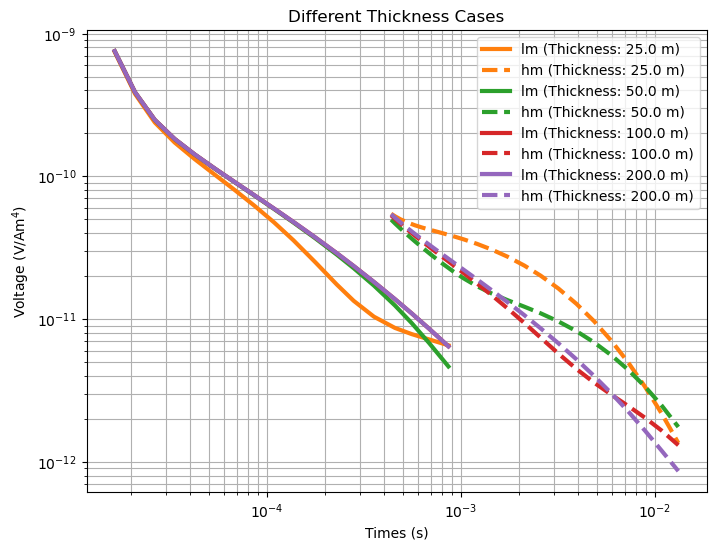

In [138]:
# Define the conductivity model
conductivity_model = [0.01, 1.0, 0.01]

# Define the four thickness cases
thickness_cases = [
    [25.0, 25.0],
    [25.0, 50.0],
    [25.0, 100.0],
    [25.0, 200.0]
]

# Plot each thickness case on the same graph with different colors and labels
fig, ax = plt.subplots(figsize=(8, 6))

colors = ['C1', 'C2', 'C3', 'C4', 'C5']

for i, layer_thicknesses in enumerate(thickness_cases):
    # Define model and mapping for a conductivity model.
    conductivity_map = maps.IdentityMap(nP=n_layers)

    simulation_conductivity = tdem.Simulation1DLayered(
        survey_skytem,
        sigmaMap=conductivity_map,
        thicknesses=layer_thicknesses,
    )

    dpred_conductivity = simulation_conductivity.dpred(conductivity_model)

    dpred_lm = -dpred_conductivity[:18]
    dpred_hm = -dpred_conductivity[18:]

    ax.loglog(LM_times, dpred_lm, colors[i], lw=3, label=f"lm (Thickness: {layer_thicknesses[1]} m)")
    ax.loglog(HM_times, dpred_hm, colors[i], lw=3, linestyle='--', label=f"hm (Thickness: {layer_thicknesses[1]} m)")

ax.grid(which="both")
ax.set_xlabel("Times (s)")
ax.set_ylabel("Voltage (V/Am$^4$)")
ax.set_title("Different Thickness Cases")
ax.legend()
plt.show()


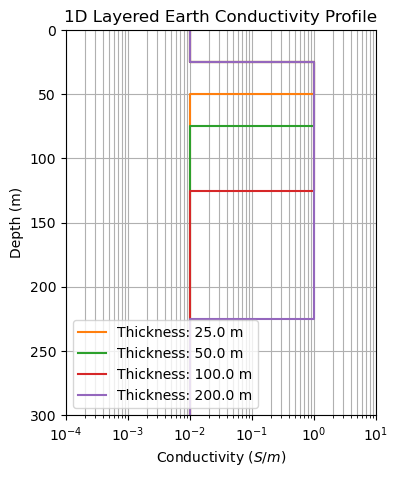

In [57]:
# Define the conductivity model
conductivity_model = [0.01, 1.0, 0.01]

# Define the four thickness cases
thickness_cases = [
    [25.0, 25.0],
    [25.0, 50.0],
    [25.0, 100.0],
    [25.0, 200.0]
]

# Colors for each case
colors = ['C1', 'C2', 'C3', 'C4', 'C5']

# Plot each thickness profile
fig, ax = plt.subplots(figsize=(4, 5))

for i, layer_thicknesses in enumerate(thickness_cases):
    plot_1d_layer_model(
        layer_thicknesses, conductivity_model, scale="log", ax=ax, color=colors[i], label=f"Thickness: {layer_thicknesses[1]} m"
    )

ax.grid(which="both")
ax.set_title("1D Layered Earth Conductivity Profile")
ax.set_xlabel(r"Conductivity ($S/m$)")
ax.set_ylabel("Depth (m)")
ax.set_xlim(1e-4, 1e1)
ax.set_ylim(300, 0)
ax.legend()
plt.show()
